Will try to discover clusters on the ordinal variables in this worksheet.

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import re, nltk, operator, itertools, gensim, math
from collections import defaultdict
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from operator import itemgetter
from gensim import corpora, models

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler

import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

In [59]:
df = pd.read_csv('corporate_culture_trunc.csv') #reads csv into dataframe
df = df.dropna(subset=['Q1']) #drop row if no description (NaN in Q1)
##TAKE ONLY THE ORDINAL VARIABLES
dfordinal = df.drop(['Q1', 'Q4b_Other_Reasons','Q5_Other','Q6_Other','Q8b_B_Perfect','Q13_5_Other','Q13_for_finance_Other','Q13_against_finance_Other'], axis=1)
dfordinal = dfordinal.drop(['Q13_for_comp_Other','Q13_against_comp_Other'],axis=1)
dfordinal = dfordinal.drop(['Q14_Other','Q14_OE_1','Q14_OE_2','Q14_OE_3','Q14_OE_4','Q14_OE_5','Q14_OE_6','Q14_OE_7','Q14_OE_8','Q14_OE_9','Q14_OE_10','Q14_OE_9','Q14_OE_10','Q14_OE_11','Q14_OE_12'],axis=1)
dfordinal = dfordinal.drop(['job_title_other','firm_location_other','IndustryOther'],axis=1)
##fix ratings, but for now --
dfordinal = dfordinal.drop(['Credit_Rating'],axis=1)
#dfordinal = dfordinal.convert_objects(convert_numeric=True) #convert object columns to numerics when possible
dfordinal = dfordinal.apply(pd.to_numeric, errors='coerce')
dfordinal = dfordinal.fillna(0)
#dfordinal['Q5_2'] = dfordinal['Q5_2'].map({2:1,0:0})
cols_to_drop=list(range(10,24)) #dropping the columns mapping who had the most influence on culture
dfordinal = dfordinal.drop(dfordinal.columns[cols_to_drop],axis=1)
nmordinal = dfordinal.as_matrix()

# CLUSTERING VIA DBSCAN

In [68]:
X = nmordinal
X_std = StandardScaler().fit_transform(X)
# Compute DBSCAN
db = DBSCAN(min_samples=15).fit(X_std)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_std, labels))

#Silhouette coefficient near 0, indicating overlapping clusters

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Estimated number of clusters: 0


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

Obviously DBSSCAN is not going to work. Let us try hierarchical clustering.

# HIERARCHICAL CLUSTERING

(1744, 88)


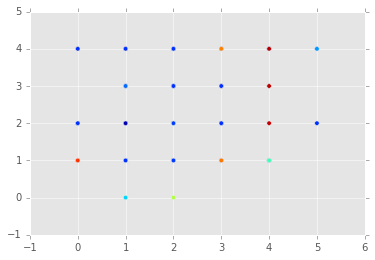

0.963060291195
-0.140586733888


In [75]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet

print(X.shape)
Z = linkage(X,'ward')
Zcos = linkage(X,metric='cosine',method='complete')
labels = fcluster(Zcos, .1, criterion="distance")
plt.scatter(X[:, 0], X[:, 1], c=labels.astype(np.float)) 
plt.show()

c, coph_dists = cophenet(Z,pdist(X))
print(c)
c, coph_dists = cophenet(Zcos,pdist(X))
print(c) 

We will go with the ward linkage, which gives much better results than the cosine similarity used for the text.

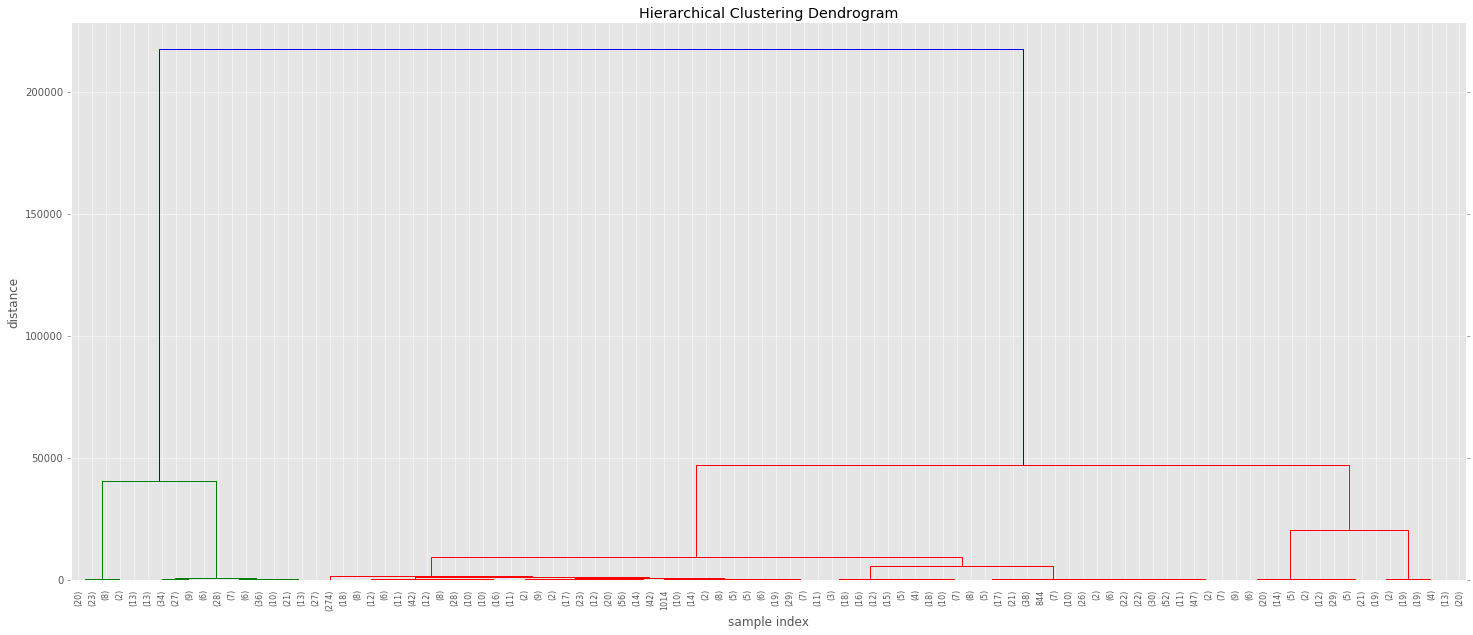

In [76]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode = 'lastp',
    p=100,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

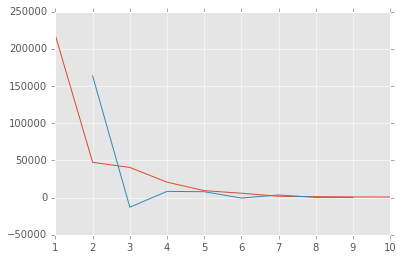

clusters: 2


In [78]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print "clusters:", k

Takeaway -- there are two main clusters, with the left being much more cohesive than the right. They can be further subdivided into four, then seven (the same number as derived manually).

# Does [Q1] reveal anything about these clusters?

In [84]:
culture_text=df['Q1'] #takes only the first column


###BELOW COMMANDS TOKENIZE TEXT#########

lmtzr = WordNetLemmatizer()
estopwords = set(stopwords.words('english')) #gets rid of stopwords (a, an, the...)
ostopwords = ['wa','ha']

def removewords(docwords,nmin,nmax):
    #removes words that only appear n times
    all_tokens=sum(docwords,[])
    tokens_n=set(word for word in set(all_tokens) if all_tokens.count(word)<=nmin or all_tokens.count(word)>=nmax)
    docwords = [[word for word in docs if word not in tokens_n]
                for docs in docwords]
    return docwords

def lemmat(corpus):
    nmin = 4
    nmax = len(corpus)/3
    token_corpus = [[re.sub(r'[^\w\-\s]','', word) for word in doc.lower().split()]
          for doc in corpus]
    token_corpus = [[lmtzr.lemmatize(w) for w in doc]
                for doc in token_corpus]
    token_corpus = [[w for w in doc if len(w)>1] #getting rid of words with only one letter
            for doc in token_corpus]
    token_corpus = [[w for w in doc if w not in estopwords] #getting rid of stopwords
            for doc in token_corpus]
    token_corpus = [[w for w in doc if w not in ostopwords] #getting rid of stopwords
            for doc in token_corpus]
    token_corpus = removewords(token_corpus,nmin,nmax)
    return(token_corpus)

tcorpus = lemmat(culture_text)

def joinlists(listname):
    #function for joining list of lists (i.e. from x=([['a','b'],['c']]) to x=['a','b','c'])
    #want only unique values for each document, so:
    uniquelitems = [set(listitems) for listitems in listname]
    newlist=list(itertools.chain.from_iterable(uniquelitems))
    return newlist

def word_count(toktext): 
    #function returns word frequences from an input of tokenized text
    word_freq=dict([(word, toktext.count(word)) for word in set(toktext)])
    return word_freq

def top_words(toktext,n):
    #function returns top n words in a tokenized text
    wordfreq=word_count(toktext)
    topwords=sorted(wordfreq.iteritems(),key=itemgetter(1), reverse=True)[:n]
    return topwords


In [127]:
# FOR A CLUSTER OF FOUR -->

k=4
clusters=fcluster(Z,k,criterion='maxclust')

dfc = { 'cluster_no' : pd.Series(clusters),
        'culture_text': pd.Series(tcorpus),
        'orig_text': pd.Series(culture_text)
      }
dfc = pd.DataFrame(dfc)
dfc['orig_text']=dfc['orig_text'].to_string()

cluster_one = dfc.loc[dfc['cluster_no'] == 1]['culture_text']
print(len(cluster_one))
tot_allwords=joinlists(cluster_one)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_two = dfc.loc[dfc['cluster_no'] == 2]['culture_text']
print(len(cluster_two))
tot_allwords=joinlists(cluster_two)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_three = dfc.loc[dfc['cluster_no'] == 3]['culture_text']
print(len(cluster_three))
tot_allwords=joinlists(cluster_three)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_four = dfc.loc[dfc['cluster_no'] == 4]['culture_text']
print(len(cluster_four))
tot_allwords=joinlists(cluster_four)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word


79
Top 10 words:
('customer', 11)
(u'employee', 8)
('culture', 8)
('collaborative', 5)
('innovative', 4)
('conservative', 4)
('innovation', 4)
('focused', 4)
('family', 4)
('high', 4)
224
Top 10 words:
('collaborative', 26)
('culture', 24)
('customer', 21)
('driven', 18)
(u'value', 17)
('focused', 15)
('respect', 14)
('oriented', 14)
('integrity', 13)
('open', 12)
1222
Top 10 words:
('culture', 95)
('family', 85)
('collaborative', 79)
(u'customer', 74)
('open', 70)
('oriented', 65)
('work', 61)
('team', 59)
('focused', 53)
(u'employee', 53)
219
Top 10 words:
('culture', 24)
('collaborative', 14)
('people', 13)
('family', 13)
(u'company', 13)
('customer', 12)
('team', 11)
('driven', 11)
('oriented', 10)
('value', 10)


For the most part, they all use the same words. What is the difference?

In [128]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import cross_validation, grid_search
from sklearn.pipeline import Pipeline
from sklearn import linear_model, ensemble
import nltk

dftc = dfc
dftc['cluster_no'] = dftc['cluster_no'].map({1:0,2:0,3:1,4:0})
dftc = dftc.dropna()
x_train, x_test, y_train, y_test = cross_validation.train_test_split(dftc['orig_text'],dftc['cluster_no'],test_size=0.5)

mypipeline=Pipeline([
  ('cvect', CountVectorizer(ngram_range=(1, 2), stop_words=nltk.corpus.stopwords.words('english'))),
  ('tfidf', TfidfTransformer()),
  ('rclassify', ensemble.RandomForestClassifier())
])

mypipeline.fit(x_train,y_train)
print(mypipeline.score(x_test,y_test))

y_pred = mypipeline.predict(x_test)


0.701834862385


In [129]:
y_obs=y_test
print "Accuracy:", metrics.accuracy_score(y_obs, y_pred)
print "Hamming Loss:", metrics.hamming_loss(y_obs, y_pred)
print "Precision:", metrics.precision_score(y_obs, y_pred)
print "Recall:", metrics.recall_score(y_obs, y_pred)
print "F1:", metrics.f1_score(y_obs, y_pred)
print "Jaccard:", metrics.jaccard_similarity_score(y_obs, y_pred)

Accuracy: 0.701834862385
Hamming Loss: 0.298165137615
Precision: 0.701834862385
Recall: 1.0
F1: 0.824797843666
Jaccard: 0.701834862385


Our words are not very good at predicting whether something belongs to the clusters identified above.

In [134]:
k=7
clusters=fcluster(Z,k,criterion='maxclust')

dfc = { 'cluster_no' : pd.Series(clusters),
        'culture_text': pd.Series(tcorpus),
        'orig_text': pd.Series(culture_text)
      }
dfc = pd.DataFrame(dfc)
dfc['orig_text']=dfc['orig_text'].to_string()

cluster_one = dfc.loc[dfc['cluster_no'] == 1]['culture_text']
print(len(cluster_one))
tot_allwords=joinlists(cluster_one)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_two = dfc.loc[dfc['cluster_no'] == 2]['culture_text']
print(len(cluster_two))
tot_allwords=joinlists(cluster_two)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word
    
cluster_three = dfc.loc[dfc['cluster_no'] == 3]['culture_text']
print(len(cluster_three))
tot_allwords=joinlists(cluster_three)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word

cluster_four = dfc.loc[dfc['cluster_no'] == 4]['culture_text']
print(len(cluster_four))
tot_allwords=joinlists(cluster_four)
print("Top 10 words:")
for ind_word in top_words(tot_allwords,10):
    print ind_word


dfc['cluster_no'] = dfc['cluster_no'].map({1:0,2:1,3:0,4:0,5:0,6:0,7:0})
dfc = dfc.dropna()
x_train, x_test, y_train, y_test = cross_validation.train_test_split(dfc['orig_text'],dfc['cluster_no'],test_size=0.5)

mypipeline=Pipeline([
  ('cvect', CountVectorizer(ngram_range=(1, 2), stop_words=nltk.corpus.stopwords.words('english'))),
  ('tfidf', TfidfTransformer()),
  ('rclassify', ensemble.RandomForestClassifier())
])

mypipeline.fit(x_train,y_train)
print(mypipeline.score(x_test,y_test))

y_pred = mypipeline.predict(x_test)
y_obs=y_test
print "Accuracy:", metrics.accuracy_score(y_obs, y_pred)
print "Hamming Loss:", metrics.hamming_loss(y_obs, y_pred)
print "Precision:", metrics.precision_score(y_obs, y_pred)
print "Recall:", metrics.recall_score(y_obs, y_pred)
print "F1:", metrics.f1_score(y_obs, y_pred)
print "Jaccard:", metrics.jaccard_similarity_score(y_obs, y_pred)

79
Top 10 words:
('customer', 11)
(u'employee', 8)
('culture', 8)
('collaborative', 5)
('innovative', 4)
('conservative', 4)
('innovation', 4)
('focused', 4)
('family', 4)
('high', 4)
224
Top 10 words:
('collaborative', 26)
('culture', 24)
('customer', 21)
('driven', 18)
(u'value', 17)
('focused', 15)
('respect', 14)
('oriented', 14)
('integrity', 13)
('open', 12)
780
Top 10 words:
('culture', 58)
('collaborative', 54)
('team', 45)
('family', 44)
('open', 43)
('work', 41)
('oriented', 41)
('customer', 39)
('focused', 32)
('professional', 32)
116
Top 10 words:
(u'employee', 10)
('customer', 9)
('service', 8)
('oriented', 8)
('integrity', 7)
('culture', 7)
('family', 6)
('entrepreneurial', 6)
('collaborative', 6)
('excellence', 5)
0.871559633028
Accuracy: 0.871559633028
Hamming Loss: 0.128440366972
Precision: 0.0
Recall: 0.0
F1: 0.0
Jaccard: 0.871559633028


Apparently, what is written in the text is not reflective of the natural clusters formed via the structured variables.
[In other words, there are natural divisions that form among the companies investigated. However, they have little to do with the culture as explained verbally.]
Future steps: concatenate all the written text together, see if whether there is more of a difference then.